In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import xgboost
import lightgbm
import missingno
import sklearn

print(xgboost.__version__)
print(lightgbm.__version__)
print(missingno.__version__)
print(sklearn.__version__)

1.4.2
3.3.0
0.5.0
1.0


## **데이터 준비**

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [3]:
import os

data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [4]:
# 정답 레이블 분리
y = train['price']
del train['price']

# 컬럼, shape 확인
print('train : ', train.columns, train.shape)
print('test : ', test.columns, test.shape)

train :  Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object') (15035, 20)
test :  Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object') (6468, 20)


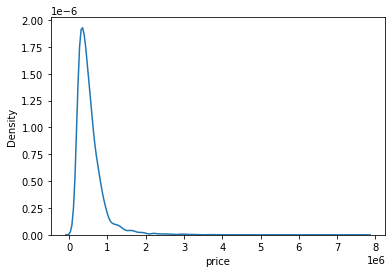

In [5]:
# 정답 레이블 분포 확인
sns.kdeplot(y)
plt.show()

 - 왼쪽으로 너무 치우져져 있어서 log 변환 << 추후 np.expm1()로 복구해야 함

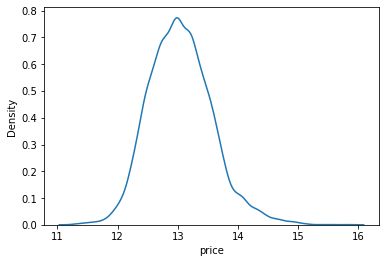

In [6]:
# 정답 레이블 log 변환 후 분포 확인
y = np.log1p(y)

sns.kdeplot(y) 
plt.show()

## **데이터 전처리**

In [7]:
# train data 확인
train.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [8]:
# test data 확인
test.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [9]:
# 지저분한 date 꼬리 자르기
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

# 필요없는 id 컬럼 삭제
del train['id']
del test['id']

# 재건축 여부를 알 수 없기 때문에 15년 기준 컬럼 삭제
train = train.drop(['sqft_living15','sqft_lot15'], axis=1)
test = test.drop(['sqft_living15','sqft_lot15'], axis=1)

#### train data로 데이터 경향 살피기

<AxesSubplot:>

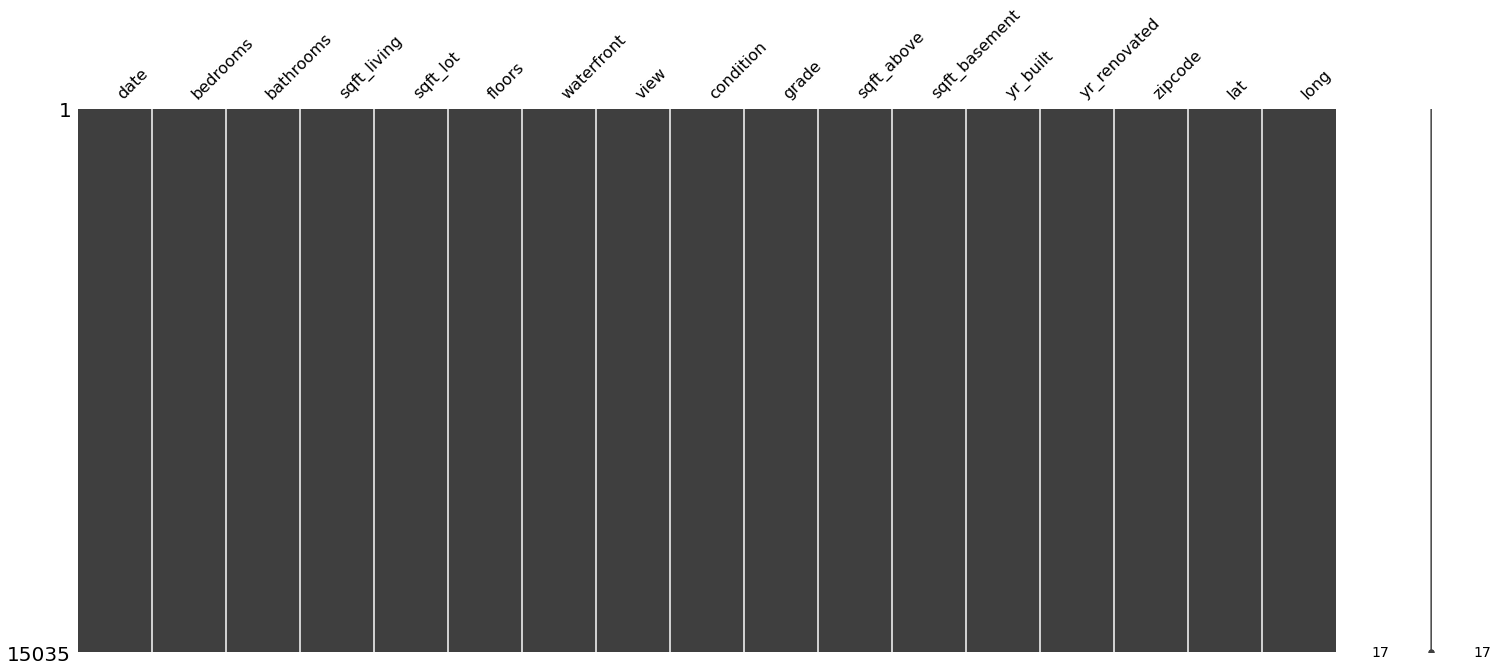

In [10]:
# 결측치 시각화 
msno.matrix(train)

In [11]:
# 한번 더 확실하게 확인
train.isna().sum()

date             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
dtype: int64

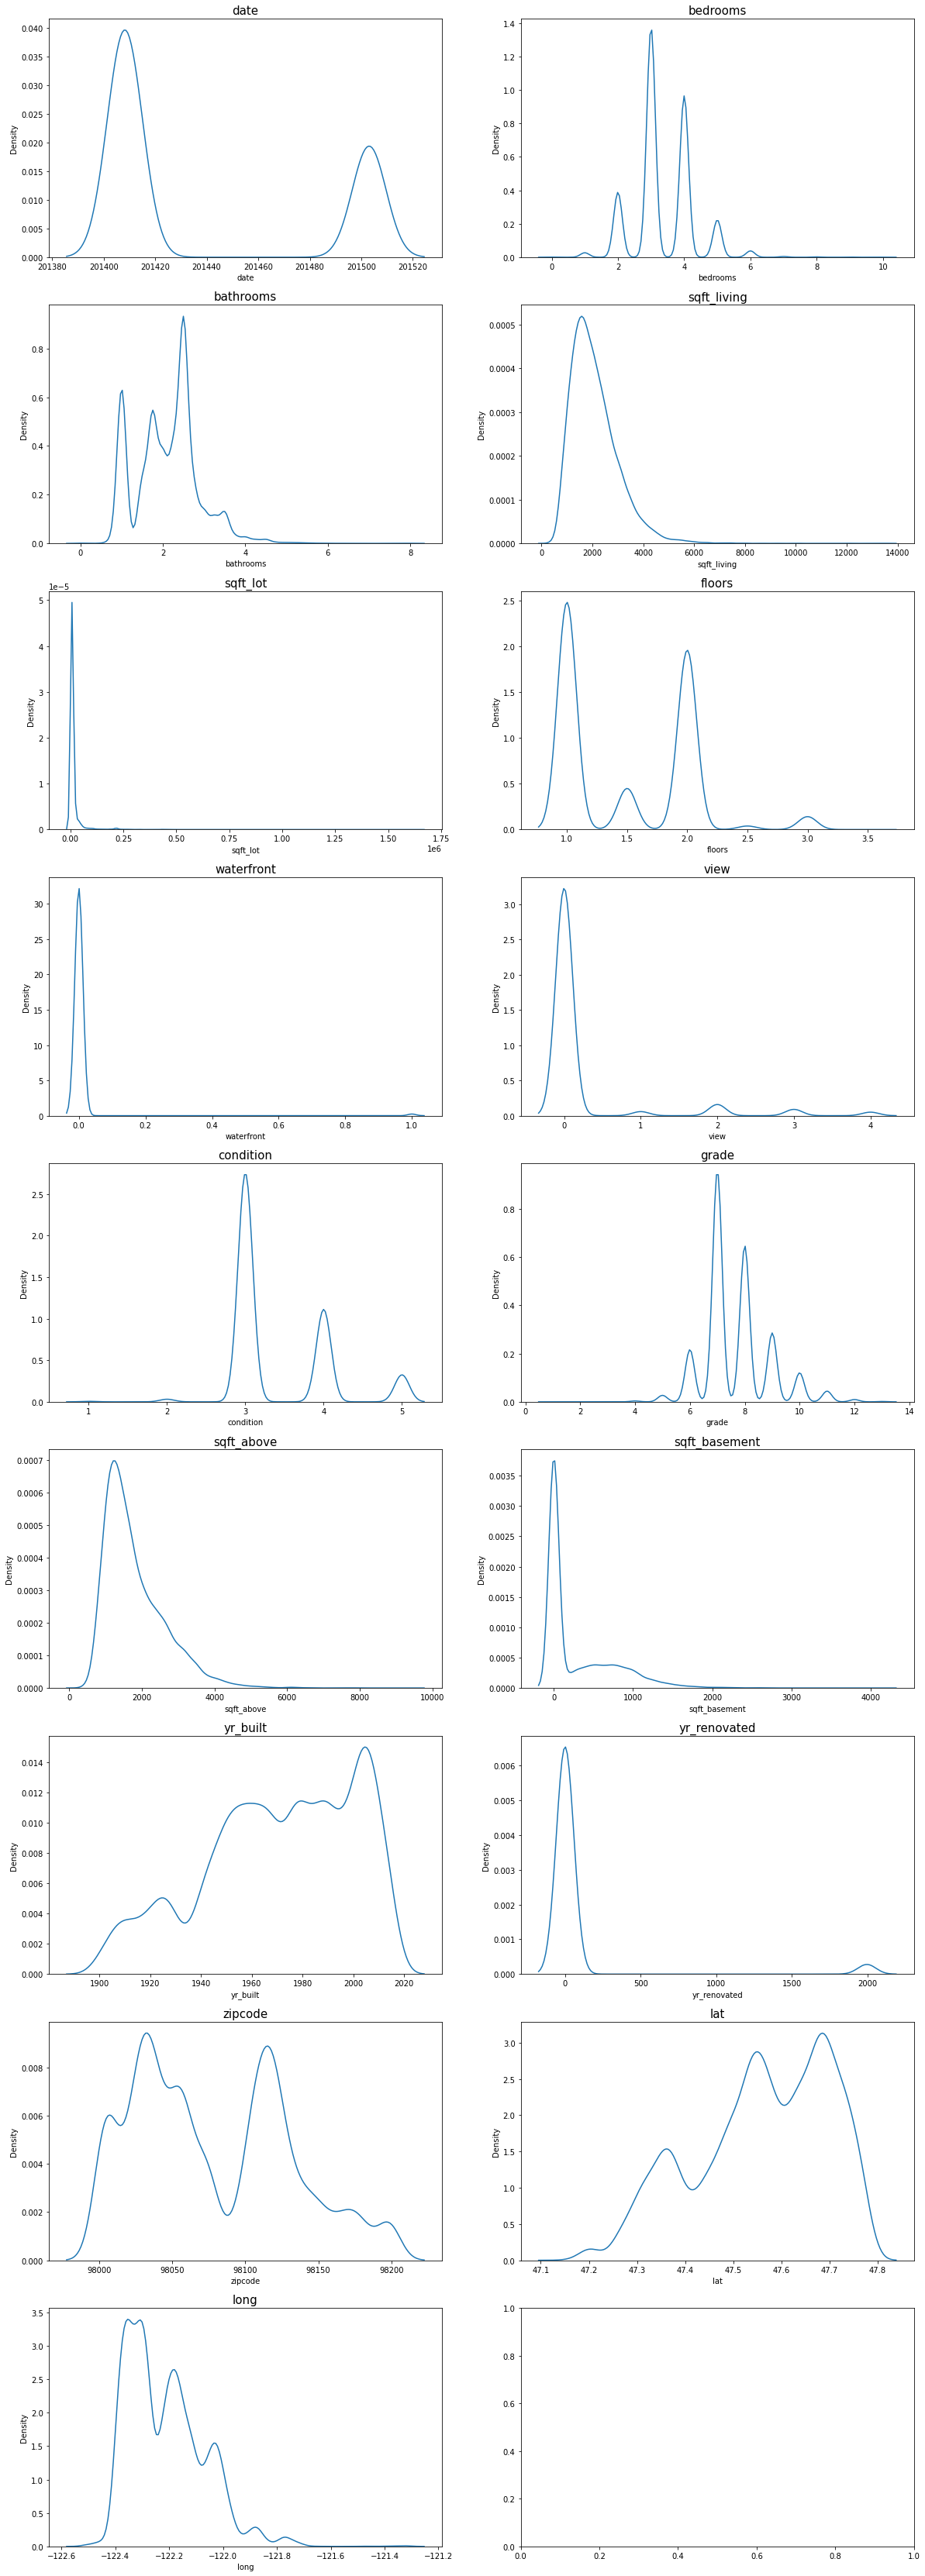

In [12]:
fig, ax = plt.subplots(9, 2, figsize=(20, 60))

# 각 컬럼의 분포를 확인
count = 0
columns = train.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 17 :
            break

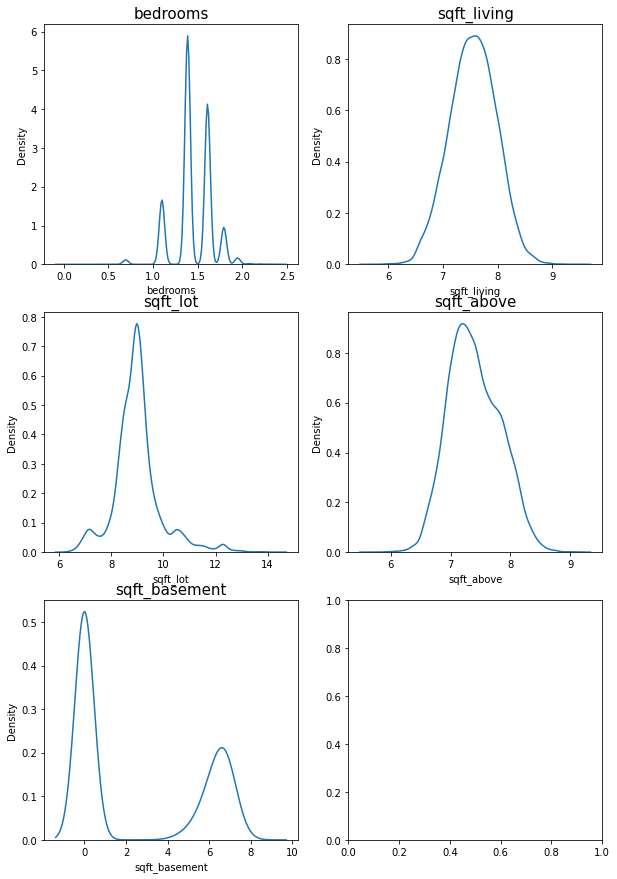

In [13]:
# # 한쪽으로 치우친 컬럼들에 대한 log scaling
# skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

# for c in skew_columns:
#     train[c] = np.log1p(train[c].values)
    
# fig, ax = plt.subplots(3, 2, figsize=(10, 15))

# count = 0
# for row in range(3):
#     for col in range(2):
#         if count == 5:
#             break
#         sns.kdeplot(train[skew_columns[count]], ax=ax[row][col])
#         ax[row][col].set_title(skew_columns[count], fontsize=15)
#         count+=1

## **모델링**

In [14]:
random_state=2023        # 일정한 모델 예측 결과를 위한 고정값 세팅

# 사용할 모델들
gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = xgb.XGBRegressor(random_state=random_state)
lightgbm = lgb.LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [15]:
# log scaling한 정답 레이블 복구 후 rmse 연산
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

# 
def get_scores(models, train, y):
    df = {}

    for model in models:    # 위에 리스트에 넣어놓은 모델들을 하나씩 꺼내서 for문 
        model_name = model.__class__.__name__

        X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=random_state)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=True)    # 모델 비교하기 위해 sorting

    return score_df


In [16]:
# 모델 fit, predict
get_scores(models, train, y)

,RMSE
LGBMRegressor,117444.592855
XGBRegressor,124034.384716
GradientBoostingRegressor,130463.577571
RandomForestRegressor,138810.247402


 - LGBMRegressor의 RMSE가 가장 낮으므로 해당 모델로 GridSearch 진행

In [17]:
# GridSearch 후 best_parameter 선택 위한 점수 테이블 반환 
# verbose=1 : loss 연산만 보이게, n_jobs=-1 : cpu 가능한만큼
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=-1):    
    model = GridSearchCV(model, param_grid=param_grid,
                        scoring='neg_mean_squared_error',      # 모델 성능: -mse로 평가
                        cv=5, verbose=verbose, n_jobs=n_jobs)    # cross validation : 5
    
    model.fit(train, y)

    params = model.cv_results_['params']                     # 파라미터
    score = model.cv_results_['mean_test_score']             # 모델 성능 점수
    result_df = pd.DataFrame(params)                         # 테이블 생성
    result_df['score'] = score                               # 모델 성능 점수 기입
    result_df['RMSLE'] = np.sqrt(-1 * result_df['score'])    # RMSLE로 점수 환산
    result_df = result_df.sort_values('RMSLE')               # RMSLE 기준으로 정렬

    return result_df

In [18]:
# 기존 노드에서 실행해본 하이퍼파라미터 + chat GPT 추천 하이퍼파라미터
# 한번에 하면 시간이 너무 오래걸려서 나눠서 진행
# Q)
'''
Can you recommend max_depth, learning_rate, n_estimators, num_leaves, boosting_type for lightgbm? 
I will use GridSearch. 
So I want 2 or 3 numbers each of them. 
'''

# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [3, 5, 7, 10],
#     'learning_rate' : [0.05, 0.1, 0.2],
#     'num_leaves' : [31, 63, 127],
#     'boosting_type' : ['gbdt','dart', 'goss']
# }


# model = lgb.LGBMRegressor(random_state=random_state)
# my_GridSearch(model, train, y, param_grid)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


,boosting_type,learning_rate,max_depth,n_estimators,num_leaves,score,RMSLE
0,gbdt,0.1,7,300,31,-0.026198,0.161858
2,goss,0.1,7,300,31,-0.027036,0.164427
1,dart,0.1,7,300,31,-0.178547,0.422548


- boosting_type='gbdt', learning_rate=0.1, max_depth=7, n_estimators=300, num_leaves=31 일 때 최대 성능인 것을 확인

In [ ]:
model = lgb.LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
np.expm1(prediction)

In [ ]:
# # AveragingBlending 활용 << 별 효과 없었음
# def AveragingBlending(model, x, y, sub_x):
#     model.fit(x, y)
#     predictions = np.column_stack([
#         model.predict(sub_x)
#     ])
#     return np.mean(predictions, axis=1)
# y_pred = AveragingBlending(model, train, y, test)

In [ ]:
# 최적모델로 전체 train 데이터로 학습 후 예측값 결과 파일 저장
def save_submission(model, train, y, test, model_name, rmsle=None):

    model.fit(train, y)
    y_pred = model.predict(test)
    y_pred = np.expm1(y_pred)

    #  결과 파일 저장
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = y_pred     # 불러온 파일에 모델 예측값 기입
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    check = pd.read_csv(submission_csv_path)
    print(check)


In [ ]:
save_submission(model, train, y, test, model_name='LGBMReg', rmsle=0.161858)